In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import cv2
import os
import numpy as np
import random
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm.notebook import tqdm
import shutil
from const import ConstWeight

In [ ]:
def seedAll(seed=355):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ["PYTHONHASHSEED"]=str(seed)

seedAll()

# Data Prep

In [ ]:
PATH ='/content/gdrive/My Drive/Sync/ML4E-Forensics/uncompressed/UNcompressed/'
CAND_RF = [0.5,0.6,0.7,0.8,0.9,1.1,1.2,1.3,1.4,1.5]
CROP_SIZE = 128

In [ ]:
def extract_images(img,crop_size=256):
    images = []
    for i in range(crop_size,img.shape[0],crop_size):
        for j in range(crop_size,img.shape[1],crop_size):
            images.append(img[i-crop_size:i,j-crop_size:j,:])
    return images

def crop_img(img):

  img = img[0:CROP_SIZE,0:CROP_SIZE,:]
  return img

In [ ]:
images = []
test_images = []
total = len(os.listdir(PATH))

for id,img in enumerate(tqdm(os.listdir(PATH))):
  try:
    image = cv2.cvtColor(cv2.imread(PATH+img),cv2.COLOR_BGR2RGB)
    temp = extract_images(image)
    test_images = test_images+temp[0::20]
    del temp[0::20]
    images = images+temp
  except:
    pass

In [ ]:
print(f"train+val set size: {len(images)}")
print(f"test set size: {len(test_images)}")

train+val set size: 11923
test set size: 648


In [ ]:

def prepare_data(images,rfs=CAND_RF):
  l = int(len(images)/10)
  to_be_rs = images[:l]
  img_shape = images[0].shape

  resized_images = []
  print(f'Resizing {l} images with {len(rfs)} candidate factors')
  for id,img in enumerate(to_be_rs):
    print(f'\rProgress: {(id+1)*100/l} %',end='',flush=True)
    for factor in rfs:
      rs_size = (int(img_shape[0]*factor),int(img_shape[1]*factor))
      rs_img = cv2.resize(img,rs_size,interpolation=cv2.INTER_CUBIC)
      resized_images.append(rs_img)
  
  labels = [[1,0] for i in range(len(images))]+[[0,1] for i in range(len(resized_images))]
  images = images+resized_images

  print(f'\nCropping images to size ({CROP_SIZE},{CROP_SIZE})')
  for id,img in enumerate(images):
    print(f'\rProgress: {(id+1)*100/len(images)} %',end='',flush=True)
    images[id] = np.expand_dims(cv2.cvtColor(crop_img(img),cv2.COLOR_BGR2GRAY).astype('float32'),axis=2)
  return np.stack(images),np.array(labels)

X,Y = prepare_data(images)
X_test,Y_test = prepare_data(test_images)
X_train,X_val,Y_train,Y_val = train_test_split(X,Y,test_size=0.2,random_state=1001)

Resizing 1192 images with 10 candidate factors
Progress: 100.0 %
Cropping images to size (128,128)
Progress: 100.0 %Resizing 64 images with 10 candidate factors
Progress: 100.0 %
Cropping images to size (128,128)
Progress: 100.0 %

In [ ]:
print(f"final trainset size: {len(X_train)}")
print(f"final val set size: {len(X_val)}")
print(f"final test set size: {len(X_test)}")

final trainset size: 19074
final val set size: 4769
final test set size: 1288


In [ ]:
X_train.shape

(19074, 128, 128, 1)

# Model Trainining

In [ ]:
CAND_RF = [0.5,0.6,0.7,0.8,0.9,1.1,1.2,1.3,1.4,1.5]
CROP_SIZE = 128

In [ ]:
# class DataLoader:
#   def __init__(self,path=None):
#     """ 
#     custom ImageDataGenerator Object
#     ++++++++++++++++++++++++++++++++++++++++++
#     path: path to directory of images

#     Example:

#     data = DataLoader(path="/content/gdrive/My Drive/Sync/UCR/Train)
#     loader = data.flow(batch_size=64)
#     model.fit_generator(loader)
#     """
#     self.files = os.listdir(path)
#     np.random.shuffle(self.files)
#     self.path = path

#   def extract_label(self,a):
#     return float(a.split('_')[-1].split('TIF')[0][:-1])

#   def image_reader(self,files):
#     for img in files:
#       im = cv2.cvtColor(cv2.imread(self.path+img),cv2.COLOR_BGR2GRAY).astype('float32')
#       im = np.expand_dims(im,axis=2)
#       lab = self.extract_label(img)
#       label = np.zeros(10)
#       label[CAND_RF.index(lab)] = 1
#       yield im,label
  
#   def batch_generator(self,items,batch_size):
#     a=[]
#     i=0
#     for item in items:
#       a.append(item)
#       i+=1

#       if i%batch_size==0:
#         yield a
#         a=[]
#     if len(a) is not 0:
#       yield a
  
#   def flow(self,batch_size):
#     """
#     flow from given directory in batches
#     ==========================================
#     batch_size: size of the batch
#     """
#     path = self.files
#     while True:
#       for bat in self.batch_generator(self.image_reader(path),batch_size):
#         batch_images = []
#         batch_labels = []
#         for im,im_label in bat:
#           batch_images.append(im)
#           batch_labels.append(im_label)
#         batch_images = np.stack(batch_images,axis=0)
#         batch_labels =  np.stack(batch_labels,axis=0)
#         yield batch_images,batch_labels

In [ ]:
class ConvConst(tf.keras.models.Model):
  def __init__(self,num_classes=10):
    super(ConvConst,self).__init__()
    self.n_classes = num_classes
    self.block1 = L.Conv2D(3,(5,5),strides=1,input_shape=(None,128,128,1))
    
    self.block2 = tf.keras.models.Sequential([
                                              L.Conv2D(96,(7,7),strides=2),
                                              L.BatchNormalization(),
                                              L.Activation('tanh'),
                                              L.MaxPool2D(pool_size=(3,3),strides=2)
    ])
    
    self.block3 = tf.keras.models.Sequential([
                                             L.Conv2D(64,(5,5),strides=1),
                                             L.BatchNormalization(),
                                             L.Activation('tanh'),
                                             L.MaxPool2D(pool_size=(3,3),strides=2)
    ])

    self.block4 = tf.keras.models.Sequential([
                                             L.Conv2D(64,(5,5),strides=1),
                                             L.BatchNormalization(),
                                             L.Activation('tanh'),
                                             L.MaxPool2D(pool_size=(3,3),strides=2)
    ])

    self.block5 = tf.keras.models.Sequential([
                                             L.Conv2D(128,(1,1),strides=1),
                                             L.BatchNormalization(),
                                             L.Activation('tanh'),
                                             L.AveragePooling2D(pool_size=(3,3),strides=2)
    ])
    
    self.fc1 = L.Dense(200)
    self.fc2 = L.Dense(200)
    self.fc3 = L.Dense(num_classes,activation="softmax")

  def call(self,inputs,**kwargs):
    out = self.block1(inputs)
    out = self.block2(out)
    out = self.block3(out)
    out = self.block4(out)
    out = self.block5(out)
    out = L.Flatten()(out)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

In [ ]:
K.clear_session()
model = ConvConst(2)
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3,momentum=0.95,decay=0.0005)
model.compile(loss="categorical_crossentropy",optimizer=optimizer,metrics=["accuracy"])
model.build((None,128,128,1))
model.summary()

Model: "conv_const"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  78        
_________________________________________________________________
sequential (Sequential)      (None, 29, 29, 96)        14592     
_________________________________________________________________
sequential_1 (Sequential)    (None, 12, 12, 64)        153920    
_________________________________________________________________
sequential_2 (Sequential)    (None, 3, 3, 64)          102720    
_________________________________________________________________
sequential_3 (Sequential)    (None, 1, 1, 128)         8832      
_________________________________________________________________
dense (Dense)                multiple                  25800     
_________________________________________________________________
dense_1 (Dense)              multiple                  4

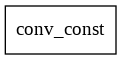

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
def schedule(epoch,lr):
  if epoch%6==0:
    return lr*0.5
  else:
    return lr

In [ ]:
chckpt = tf.keras.callbacks.ModelCheckpoint('model.hdf5',save_best_only=True,save_weights_only=True,monitor="val_accuracy",mode="max")
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)

In [ ]:
from IPython.display import clear_output
class loss_plt(tf.keras.callbacks.Callback):
  def on_train_begin(self,logs={}):
    self.losses = []
    self.val_losses =[]
    self.accuracy = []
    self.val_accuracy =[]

  def on_epoch_end(self,epoch,logs={}):
    clear_output(wait=True)
    self.val_losses.append(logs.get('val_loss'))
    self.losses.append(logs.get('loss'))

    self.val_accuracy.append(logs.get('val_accuracy'))
    self.accuracy.append(logs.get('accuracy'))

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(self.val_losses,color="green",label="val_loss")
    plt.plot(self.losses,color="red",label="loss")
    plt.legend()
    plt.title("loss curve");

    plt.subplot(1,2,2)
    plt.plot(self.val_accuracy,color="green",label="val_accuracy")
    plt.plot(self.accuracy,color="red",label="accuracy")
    plt.legend()
    plt.title("accuracy curve");
    plt.tight_layout()
    plt.show()

loss_cback = loss_plt()

In [ ]:
# val_X = []
# val_Y = []
# l = len(os.listdir(PATH+"Test/"))

# def extract_label(a):
#     return float(a.split('_')[-1].split('TIF')[0][:-1])

# for id,img in enumerate(tqdm(os.listdir(PATH+"Test/"))):
#   im = cv2.cvtColor(cv2.imread(PATH+"Test/"+img),cv2.COLOR_BGR2GRAY).astype('float32')
#   im = np.expand_dims(im,axis=2)
#   lab = extract_label(img)
#   label = np.zeros(10)
#   label[CAND_RF.index(lab)] = 1
#   val_X.append(im)
#   val_Y.append(label)

# val_X = np.stack(val_X)
# val_Y = np.stack(val_Y)

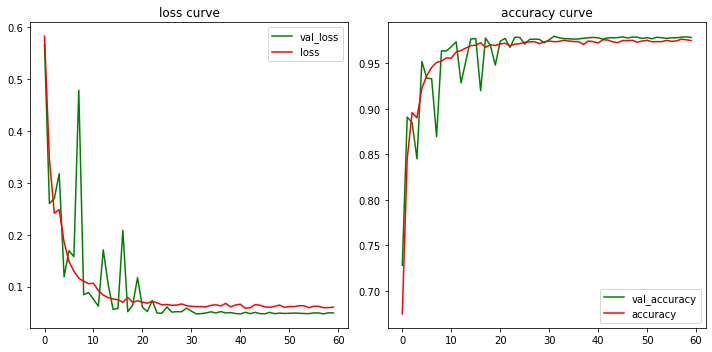

In [ ]:
# train_load = DataLoader(PATH+'Train/')
# train = train_load.flow(batch_size=64)
weight_cback = ConstWeight(3)

history = model.fit(X_train,Y_train,
                    epochs=60,
                    validation_data=(X_val,Y_val),
                    callbacks=[chckpt,loss_cback,weight_cback,lr_scheduler],verbose=1
                    )

# Model Test with Unseen Image

(3264, 4928, 3)


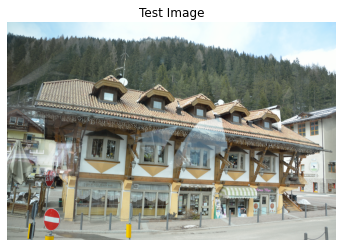

In [ ]:
im = cv2.cvtColor(cv2.imread('/content/r0284aa1at.TIF'),cv2.COLOR_BGR2RGB)
plt.imshow(im);
plt.axis("off")
plt.title("Test Image");
print(im.shape)

In [ ]:
# def prepare_eval(image_list,crop_size=512,rfs= CAND_RF):
#   images = []
#   for im in image_list:
#     img = cv2.cvtColor(cv2.imread('/content/'+im),cv2.COLOR_BGR2RGB)
#     for i in range(crop_size,img.shape[0],crop_size):
#         for j in range(crop_size,img.shape[1],crop_size):
#             images.append(img[i-crop_size:i,j-crop_size:j,:])
#   resized_images = []
#   labels = []
#   l = len(images)//10
#   for im in images[:l]:
#     for rf in rfs:
#       label = [1,0]
#       labels.append(label)
#       r_img = cv2.resize(im,(int(im.shape[0]*rf),int(im.shape[1]*rf)),interpolation=cv2.INTER_CUBIC)
#       r_img = cv2.cvtColor(r_img,cv2.COLOR_RGB2GRAY)[:256,:256]
#       resized_images.append(np.expand_dims(r_img.astype('float32'),axis=2))
  
#   l = len(images)
#   images = [np.expand_dims(cv2.cvtColor(i,cv2.COLOR_RGB2GRAY)[:256,:256],axis=2) for i in images]+resized_images
#   labels = [[0,1] for _ in range(l)]+labels

#   return np.stack(images),np.stack(labels)

# X_eval,Y_eval = prepare_eval(['original_image.TIF'])
# X_eval,Y_eval = shuffle(X_eval,Y_eval)

In [ ]:
# X_eval.shape

(25, 256, 256, 1)

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [ ]:
model.load_weights('model.hdf5')
pred = model.predict(X_test)
pred = [np.argmax(p) for p in pred]

In [ ]:
y = [np.argmax(p) for p in Y_test]

In [ ]:
print(accuracy_score(y,pred))

0.9759316770186336


In [ ]:
print(classification_report(y,pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       648
           1       0.98      0.97      0.98       640

    accuracy                           0.98      1288
   macro avg       0.98      0.98      0.98      1288
weighted avg       0.98      0.98      0.98      1288

